In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import json
import glob
from PIL import Image
from tqdm.notebook import tqdm
from pathlib import Path
from dataclasses import dataclass
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import seaborn as sns
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# functions to process txt data
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray
        
def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue
            
        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])
            
    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [3]:
dataset_path = Path('../input/indoor-location-navigation')
os.listdir(dataset_path)

['metadata', 'sample_submission.csv', 'test', 'train']

# train data

In [4]:
train_sites = os.listdir(dataset_path/"train")
print("unique training site: ", len(set(train_sites)))

unique training site:  204


In [5]:
example_site = os.listdir(dataset_path/"train")[10]
example_site_path = dataset_path/"train"/example_site
print('Floors for example site:', example_site)
print(os.listdir(example_site_path))

Floors for example site: 5cd969b639e2fc0b4afe6db1
['B1', 'F1', 'F4', 'F3', 'F2']


In [6]:
print('Path text files for example floor:')
for i in os.listdir(example_site_path):
    print(i, os.listdir(example_site_path/i))

Path text files for example floor:
B1 ['5d08da465ded320009ea9cf4.txt']
F1 ['5d08ceb8b1253b0008b9765c.txt']
F4 ['5d08d531b1253b0008b97680.txt']
F3 ['5d08d3485ded320009ea9ce3.txt']
F2 ['5d08d0b45ded320009ea9cd5.txt']


In [7]:
text_nums = []
for site in os.listdir(dataset_path/"train"):
    for floor in os.listdir(dataset_path/"train"/site):
        text_nums.append(len(os.listdir(dataset_path/"train"/site/floor)))

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

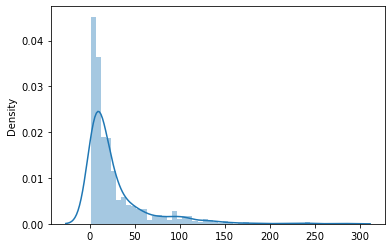

In [8]:
# あるsiteのあるfloorごとにどれだけのファイルがあるか。かなり偏りがある
sns.distplot(text_nums)

In [9]:
text_patterns = []
for site in os.listdir(dataset_path/"train"):
    for floor in os.listdir(dataset_path/"train"/site):
        for i in (os.listdir(dataset_path/"train"/site/floor)):
            floor_patterns.append()

NameError: name 'floor_patterns' is not defined

In [10]:
floors_per_site = []
for i in os.listdir(dataset_path/"train"): 
    floors_per_site.append(len(os.listdir(dataset_path/"train"/i)))
print(f'There are a total of {sum(floors_per_site)} floors. On average, each site has {np.mean(floors_per_site)} floors')

There are a total of 981 floors. On average, each site has 4.8088235294117645 floors


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

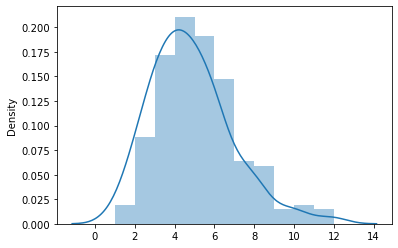

In [11]:
sns.distplot(floors_per_site)

# test data

In [12]:
test_sites = os.listdir(dataset_path/"test")
print("unique test site: ", len(set(test_sites)))

unique test site:  626


In [13]:
# test data only includes path text data
example_site = os.listdir(dataset_path/"test")[10]
print('Floors for example site:', example_site)
for i in os.listdir(dataset_path/"test"):
    print(i, end=" ")

Floors for example site: f0d402a465655bfc8ab41242.txt
52ad8c760ff9978d0949deed.txt fd4eee038c0ad7f0179e337e.txt 5694e13f4bb0bac39806b5ae.txt 7d3f0c002431353bc0a54eeb.txt e8ed3f22ef83d9515ce36e8f.txt 19bf3d9c5236d0f7429baa6a.txt f971e55da42b78e4d7a628e8.txt 7efc4326b753c9133e0b908e.txt 35b801b06a7816dc8a77080c.txt 4aaa69d3ff7e13ed5e824aa2.txt f0d402a465655bfc8ab41242.txt ad97a5e58725339a560c381e.txt dc78498813d06eff01a96320.txt 05d052dde78384b0c543d89c.txt 6085d88383432829bafe3147.txt 8545d8808a11f6b48d112310.txt 3506b3b626f494b0f0b934ca.txt 6913609ad03d8092c8b5b822.txt 8d64c2a46bc9b91426969ef6.txt f31f1f8ec42e10d23cb54ec4.txt 3e61e72b06bc6f787d9b176f.txt 1e85728385bc83e6bb650798.txt 723900eb4d292e35981c3012.txt 2ae8bd41bbf2eb78d76d737d.txt 446d199192f9d69464b77ffd.txt cc23760c1abbefee0791b1f2.txt 4ff5b9152353b3dc458992fa.txt a25a8d841f9dcb508c5ee363.txt 5582270fcaee1f580de9006f.txt b82e65dde03a9ff7b676fd37.txt 6913691fa6371ba1be81276e.txt 75703a1e62aa93e8c56de7aa.txt 4d4315146c8acfc8f7

# metadata

In [14]:
print("unique training site: ", len(os.listdir(dataset_path/"metadata")))

unique training site:  204


In [15]:
set(os.listdir(dataset_path/"metadata")) == set(train_sites)

True

In [16]:
metadata_example_site = os.listdir(dataset_path/"metadata")[0]
metadata_example_site_path = dataset_path/"metadata"/metadata_example_site
metadata_example_floor_path = dataset_path/"metadata"/metadata_example_site/os.listdir(metadata_example_site_path)[0]
print(os.listdir(metadata_example_floor_path))

['geojson_map.json', 'floor_info.json', 'floor_image.png']


In [17]:
os.listdir(metadata_example_site_path)

['B1', 'F3', 'F2']

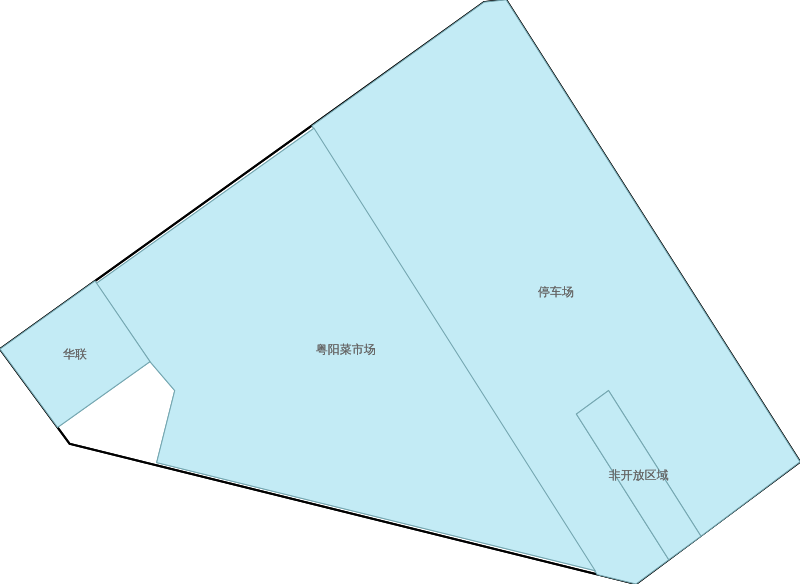

In [18]:
Image.open(metadata_example_floor_path/'floor_image.png')

In [19]:
with open(metadata_example_floor_path/'geojson_map.json') as geojson_map:
    data = json.load(geojson_map)
    geojson_map.close()
print(data)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'geometry': {'type': 'MultiPolygon', 'coordinates': [[[[13533491.764994005, 3665879.745131374], [13533397.588704797, 3665903.054216612], [13533386.011477754, 3665918.8106623953], [13533466.495469598, 3665976.497656886], [13533470.169012794, 3665976.8883146574], [13533519.038269253, 3665900.059192012], [13533491.764994005, 3665879.745131374]]]]}, 'properties': {'Vr': '000200', 'category': 'floor', 'name': 'B1', 'code': 'TY0011430100100008', 'floor_num': -1, 'type': 'floor'}, 'order': 1, 'crs': {'type': 'link', 'properties': {'href': 'http://spatialreference.org/ref/sr-org/6928/ogcwkt/', 'type': 'ogcwkt'}}}, {'type': 'Feature', 'properties': {'id': '5cd56c0fe2acfd2d33b6b1bd', 'version': '2019-05-10T12:18:23.255Z', 'name': '停车场', 'display': '停车场', 'category': ['5d35734ddb07255e49559b2a', '5d35734edb07255e49559b4b'], 'point': [13533474.024319848, 3665934.903069379], 'points': [], 'doors': []}, 'geometry': {'coordinates': [[[135

In [20]:
with open(metadata_example_floor_path/'floor_info.json') as floor_info:
    data = json.load(floor_info)
    floor_info.close()
print(data)

{'map_info': {'height': 83.04442650447841, 'width': 113.72011124652744}}


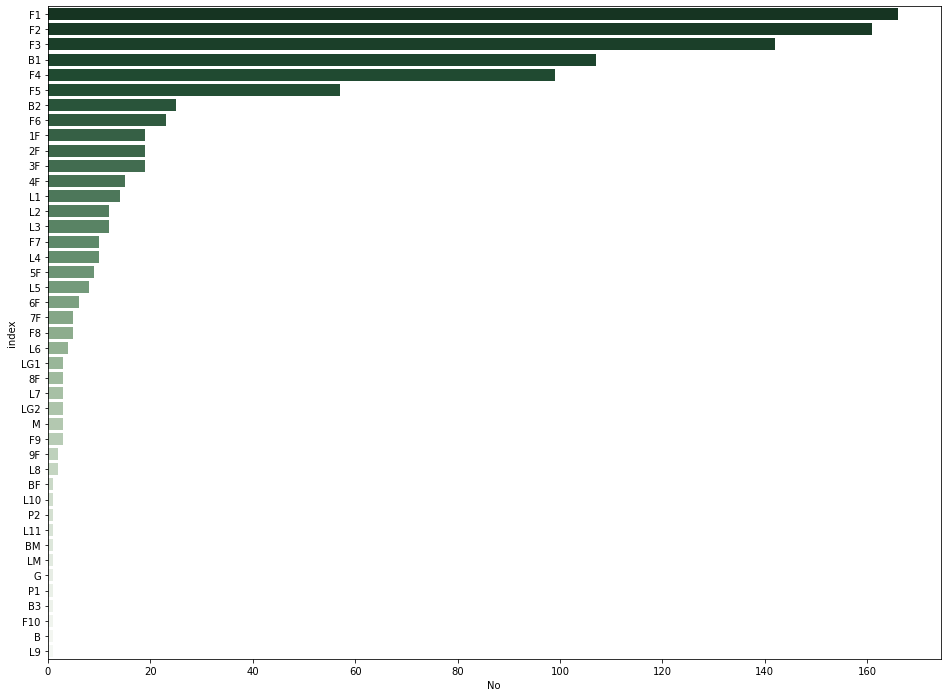

In [21]:
all_floors = glob.glob("../input/indoor-location-navigation/metadata/*/*")
floor_no = []

# Extract only the floor number
for floor in all_floors:
    no = floor.split("/")[5]
    floor_no.append(no)
    
floor_no = pd.DataFrame(floor_no, columns=["No"])
floor_no = floor_no["No"].value_counts().reset_index()
floor_no = floor_no.sort_values("No", ascending=False)

plt.figure(figsize=(16, 12))
ax = sns.barplot(data=floor_no, x="No", y="index", palette="Greens_r",
                 saturation=0.4)

# txt file

In [22]:
example_floor_path = example_site_path/'B1'
example_txt_path = example_floor_path/os.listdir(example_floor_path)[0]
with open(example_txt_path) as example_txt:
    data = example_txt.read()
    example_txt.close()

In [23]:
data

'#\tstartTime:1560861093247\n#\tSiteID:5cd969b639e2fc0b4afe6db1\tSiteName:vanke2049海上传奇\tFloorId:5cd969be39e2fc0b4afe7329\tFloorName:B1\n#\tBrand:HUAWEI\tModel:HWI-AL00\tAndroidName:8.0.0\tAPILevel:26\t\n#\ttype:1\tname:accelerometer-bmi160\tversion:1\tvendor:bosch\tresolution:0.009576807\tpower:0.23\tmaximumRange:78.4532\n#\ttype:4\tname:gyroscope-bmi160\tversion:1\tvendor:bosch\tresolution:1.7453292E-5\tpower:6.1\tmaximumRange:34.906586\n#\ttype:2\tname:akm-akm09918\tversion:1001\tvendor:akm\tresolution:0.0625\tpower:6.8\tmaximumRange:2000.0\n#\tVersionName:v20190612-nightly\tVersionCode:263\t\n1560861093249\tTYPE_WAYPOINT\t50.0394\t32.13203\n1560861093438\tTYPE_ACCELEROMETER\t0.29688102\t1.3120226\t9.921572\n1560861093438\tTYPE_MAGNETIC_FIELD\t20.4375\t-6.3125\t-9.8125\n1560861093438\tTYPE_GYROSCOPE\t0.021293016\t-0.052167892\t-0.006387905\n1560861093438\tTYPE_ROTATION_VECTOR\t0.069655\t0.028211\t0.670664\n1560861093438\tTYPE_MAGNETIC_FIELD_UNCALIBRATED\t11.375\t56.75\t-33.625\n1560

In [24]:
example_data = read_data_file(example_txt_path)

In [25]:
print(example_data.acce.shape)

print(example_data.acce_uncali.shape)

print(example_data.gyro.shape)
print(example_data.gyro_uncali.shape)
print(example_data.magn.shape)
print(example_data.magn_uncali.shape)
print(example_data.ahrs.shape)

print(example_data.wifi.shape)

print(example_data.ibeacon.shape)

print(example_data.waypoint.shape)
example_data.waypoint

(2109, 4)
(0,)
(2109, 4)
(2109, 4)
(2109, 4)
(2109, 4)
(2109, 4)
(43, 5)
(0,)
(5, 3)


array([[1.56086109e+12, 5.00394000e+01, 3.21320300e+01],
       [1.56086110e+12, 4.52659650e+01, 3.11367320e+01],
       [1.56086111e+12, 4.36638700e+01, 3.74631080e+01],
       [1.56086112e+12, 4.52659650e+01, 3.11367320e+01],
       [1.56086113e+12, 5.00394000e+01, 3.21320300e+01]])

In [26]:
acce_shape = []
acce_uncali_shape = []
gyro_shape = []
gyro_uncali_shape = []
magn_shape = []
magn_uncali_shape = []
ahrs_shape = []
wifi_shape = []
ibeacon_shape = []
test_files = os.listdir(dataset_path/'test')
for i in tqdm(range(len(test_files))):
    test_data = read_data_file(dataset_path/'test'/test_files[i])
    acce_shape.append(test_data.acce.shape)
    acce_uncali_shape.append(test_data.acce_uncali.shape)
    gyro_shape.append(test_data.gyro.shape)
    gyro_uncali_shape.append(test_data.gyro_uncali.shape)
    magn_shape.append(test_data.magn.shape)
    magn_uncali_shape.append(test_data.magn_uncali.shape)
    ahrs_shape.append(test_data.ahrs.shape)
    wifi_shape.append(test_data.wifi.shape)
    ibeacon_shape.append(test_data.ibeacon.shape)

  0%|          | 0/626 [00:00<?, ?it/s]